<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity

## Table of Content
1. [Introduction](#intro)
1. [Library import](#libraries)
1. [Data preparation](#data-prep)
1. [Classification model](#classif)
  1. [Model training](#train)
  1. [Comparative sets creation](#compar-sets)
  1. [Similarity computation](#similarity)
1. [Performance metrics](#performance)
1. [Next steps](#next)
<br>[Appendix](#appendix)

## 1. Introduction <a id="intro"/>

Aside from image classification and object detection, another typical computer vision task is image similarity.

Users who browse a retailer website may indeed be interested in finding pieces of clothing similar to one they like. Some companies may give access to their premises only to people they recognize. Such applications rely on the ability to find images similar to a reference one.

This is usually done by training a siamese network or a triplet loss model. These are advanced techniques, which tend to require a lot of resources and data. In this tutorial, we will start with a simpler method. We will indeed leverage an image classification model, extract vector representations called image embeddings, and compute the distance between them to find the image closest to a reference one.

## 2. Library import <a id="libraries"/>

Let's first load all the libraries we will need to build our model, compute distances, rank our images according to distance and display our results.

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
import numpy as np
import sys

# fast.ai
import fastai
from fastai.vision import *
from fastai.callbacks.hooks import *

# Other advanced libraries
from operator import itemgetter
from pathlib import Path
from sklearn.neighbors import BallTree
from torch.cuda import get_device_name

# Computer Vision repository
sys.path.extend([".", "../", "../.."])
# This "sys.path.extend()" statement allows us to move up the directory hierarchy 
# and access the utils_cv packages
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import gpu_info
from utils_cv.similarity.data import comparative_set_builder, SaveFeatures, test_set_extractor
from utils_cv.similarity.metrics import compute_topk_similar, positive_image_median_rank, positive_in_top_k
from utils_cv.similarity.plot import plot_rank, plot_similars
from utils_cv.similarity.widget import DistanceWidget

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
print(f"Machine's GPU info = {gpu_info()} (memory unit = MiB)")
print(f"Fast.ai/Torch is using {get_device_name(0)}")

Fast.ai version = 1.0.48


## 3. Data preparation <a id="data-prep"/>

Since we are approaching image similarity from an image classification perspective, we will then follow the steps described in the [01_training_introduction.ipynb](../../classification/notebooks/01_training_introduction.ipynb) notebook.

We start with the preparation of our data, and the setting of a few parameters. Here too, we use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. Images from each of these classes are saved in a separate folder.

In [4]:
# Set dataset, model and evaluation parameters
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS_HEAD = 4
EPOCHS_BODY = 12
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50
DISTANCE = "l2"
TOP_K = 10

# Extract data path
path = Path(DATA_PATH)

Now that our test set has been moved out of `fridgeObjects/`, i.e. out of the training folder, we can build our training data object. We can also split it to get a certain percentage (here 20%) assigned to a validation set.

Training set: 108 images
Validation set: 26 images


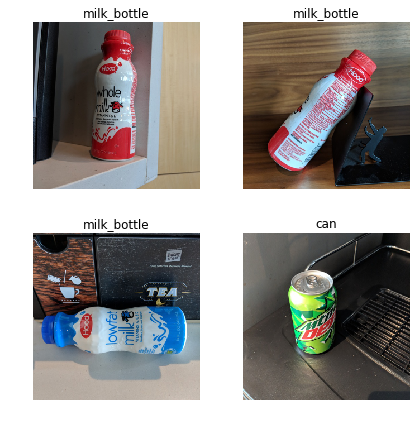

In [5]:
# Load images into fast.ai's ImageDataBunch object
data = (ImageList.from_folder(path) 
        .split_by_rand_pct(valid_pct=0.2, seed=10) 
        .label_from_folder() 
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

print(f'Training set: {len(data.train_ds.x)} images\nValidation set: {len(data.valid_ds.x)} images')

# Display example images
data.show_batch(rows=2, figsize=(6,6))

## 4. Classification model <a id="classif"/>

In this tutorial, we will use a [ResNet50](https://arxiv.org/pdf/1512.03385.pdf) architecture.

We begin by retrieving a pre-trained model from fast.ai's library.

In [6]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    # ps=0.5  # dropout rate
)

Before training it, let's look at its architecture.

In [ ]:
learn.model

Let's, more particularly, focus on the last part. Fast.ai's version of this model is composed of a different set of final layers (cf. `(1): Sequential`). These layers are such that it is easier for us to use this model with [any dataset we want](https://forums.fast.ai/t/fastai-resnet50-final-layers/43496) (and not just ImageNet, which was used to train it).

These layers, especially `(6): BatchNorm1d`, give us access to image features, i.e. to all the semantic information in a given image. These features are captured in a vector of length 512, in this case. This type of vector is called an image embedding. Such embedding will be the key to compare images, and find similar ones, as we will see below.

For now, let's create an object that will allow us to extract that embedding for any image we will run through the model.

In [7]:
# Extract features from the last batch normalization layer
im_embedding = learn.model[1][6]  ## [1][6] correspond to the indices we discussed above
print(im_embedding)

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### 4.A Model training <a id="train"/>

Let's now train the model: first, on the last layer, for a few epochs

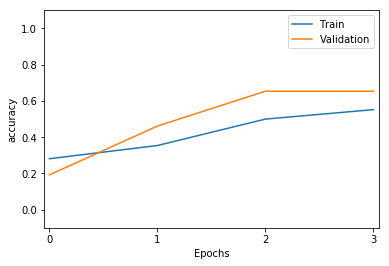

In [8]:
# Train the last layer
learn.fit_one_cycle(EPOCHS_HEAD, LEARNING_RATE)

Let's now unfreeze all the layers and fine tune the model with our data

In [9]:
learn.unfreeze()

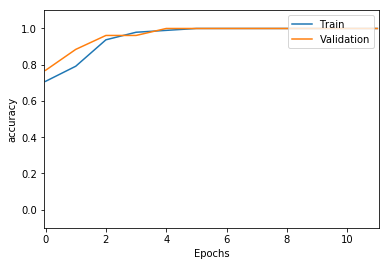

In [10]:
learn.fit_one_cycle(EPOCHS_BODY, LEARNING_RATE)

### 4.B Comparative sets creation <a id="compar-sets"/>

Our model is ready to be used to compute image embeddings. The only thing we now need is sets of comparative images. We build them here from the data set aside for validation.

Each comparative set is composed of:

- A reference image: image to which the rest of the images of the set will be compared to find similar images to it
- A positive example: image of the same class as the reference image -- If our model is well trained, we expect the positive example to be the image the most similar to the reference image
- Negative examples: set of images from all the other classes -- We expect these to be "further away" from the reference image than the positive example

Due to the randomness of the split between training and validation data, the number of images in each of the "other" classes may differ.

In the cells below, we generate these sets of image.

In [11]:
# Generate the sorted list of images that are part of the validation set
valid_im_list = sorted(list(data.valid_ds.x.items))

In [12]:
# Build multiple sets of comparative images
comparative_sets = comparative_set_builder(valid_im_list)
print(f"comparative_sets contains {len(comparative_sets)} reference images")

comparative_sets contains 26 reference images


The `comparative_sets` object is a dictionary defined as:
- key: reference image path
- value: list of paths of comparative images -- This list is composed of 1 positive and multiple negative examples.

Let's examine one of them.

In [13]:
# Retrieve the first comparative set
first_ref_im_path = list(comparative_sets.keys())[0]
first_comparative_set = comparative_sets[first_ref_im_path]

# Extract the list of paths of images to compare to the first test reference image
im_list = [str(im_path) for im_path in first_comparative_set]
first_comparative_set_paths = [first_ref_im_path] + im_list
# print(f"We will compare {first_ref_im_path} to:\n\n{im_list}")

### 4.C Similarity computation <a id="similarity"/>

For each of our comparative sets, we can now use our model to extract the corresponding image embeddings, compute the distances to the reference image, and rank the other images by distance to it.

For this, we need to first:
- save, through the `SaveFeatures()` hook, the features we obtained from the batch normalization layer we referenced above
- run the test data through the model we trained, and get the corresponding predictions using `predict()`
- extract the values of the features we just saved, i.e. the image embeddings we need to find similar images.

In [14]:
similarities_list = []
print(f"Processing:")

# For each comparative set
for reference_im_path in comparative_sets:
    print(f"--> {os.path.basename(reference_im_path)}")
    im_list = [str(im_path) for im_path in comparative_sets[reference_im_path]]
    comparative_set_paths = [reference_im_path] + im_list
    
    # Save the features of the last batch normalization layer
    featurizer = SaveFeatures(im_embedding)
    
    # Compute the predictions
    for im_path in comparative_set_paths:
        learn.predict(open_image(str(im_path)))

    # Extract the embeddings
    features = featurizer.features
    
    # Associate image path to image embedding
    # The resulting dictionary is then used in the following distance computation function (compute_topk_similar)
    feature_dict = dict(zip(comparative_set_paths, features))

    # Compute distances and rank comparative images
    reference_im_features = feature_dict[reference_im_path]
    dist_tuple = compute_topk_similar(reference_im_features, feature_dict, distance=DISTANCE, top_k=len(comparative_set_paths))
    # Here, "top_k" = total number of images in the current comparative set, 
    # so we can get the rank of the positive image, even when it is > TOP_K
    
    # Append to similarities_list, which contains 
    # the list of ranked comparative images, 
    # for each comparative set
    similarities_list.append(dist_tuple)

Processing:
--> 10.jpg
--> 11.jpg
--> 19.jpg
--> 4.jpg
--> 39.jpg
--> 40.jpg
--> 42.jpg
--> 44.jpg
--> 46.jpg
--> 48.jpg
--> 49.jpg
--> 54.jpg
--> 59.jpg
--> 60.jpg
--> 61.jpg
--> 64.jpg
--> 69.jpg
--> 83.jpg
--> 84.jpg
--> 90.jpg
--> 102.jpg
--> 110.jpg
--> 121.jpg
--> 122.jpg
--> 131.jpg
--> 133.jpg


In the cell above, for each comparative set, we extracted an embedding for the reference image and for each of the test images  (i.e. positive and negative examples). We stored them in the `features` object. We then computed distances between the reference image and the test images, and ranked the latter by increasing distance from the former. We saved the results in the `dist_tuple` object, which is a tuple of the format (reference image, [ranked test images]).

Here, we considered the $L_2$ distance, so we computed $ \sqrt{\sum_{j=1}^{512}{(emb_{ref}[j] - emb_{im}[j])^{2}}} $, where $emb_{ref}$ is the embedding of the reference image and $emb_{im}$ that of any of the comparative images.

Our `compute_topk_similar()` function can also compute other types of distances, such as L1 and cosine similarity. By default, we chose to normalize our image embeddings before computing the distance between them. This can be changed in the `compute_vector_distance()` sub-function that is available in the same library as `compute_topk_similar()`.

Now that we have ranked the test images for each of our comparative sets, let's examine some results. Below, we plot those for our first comparative set.

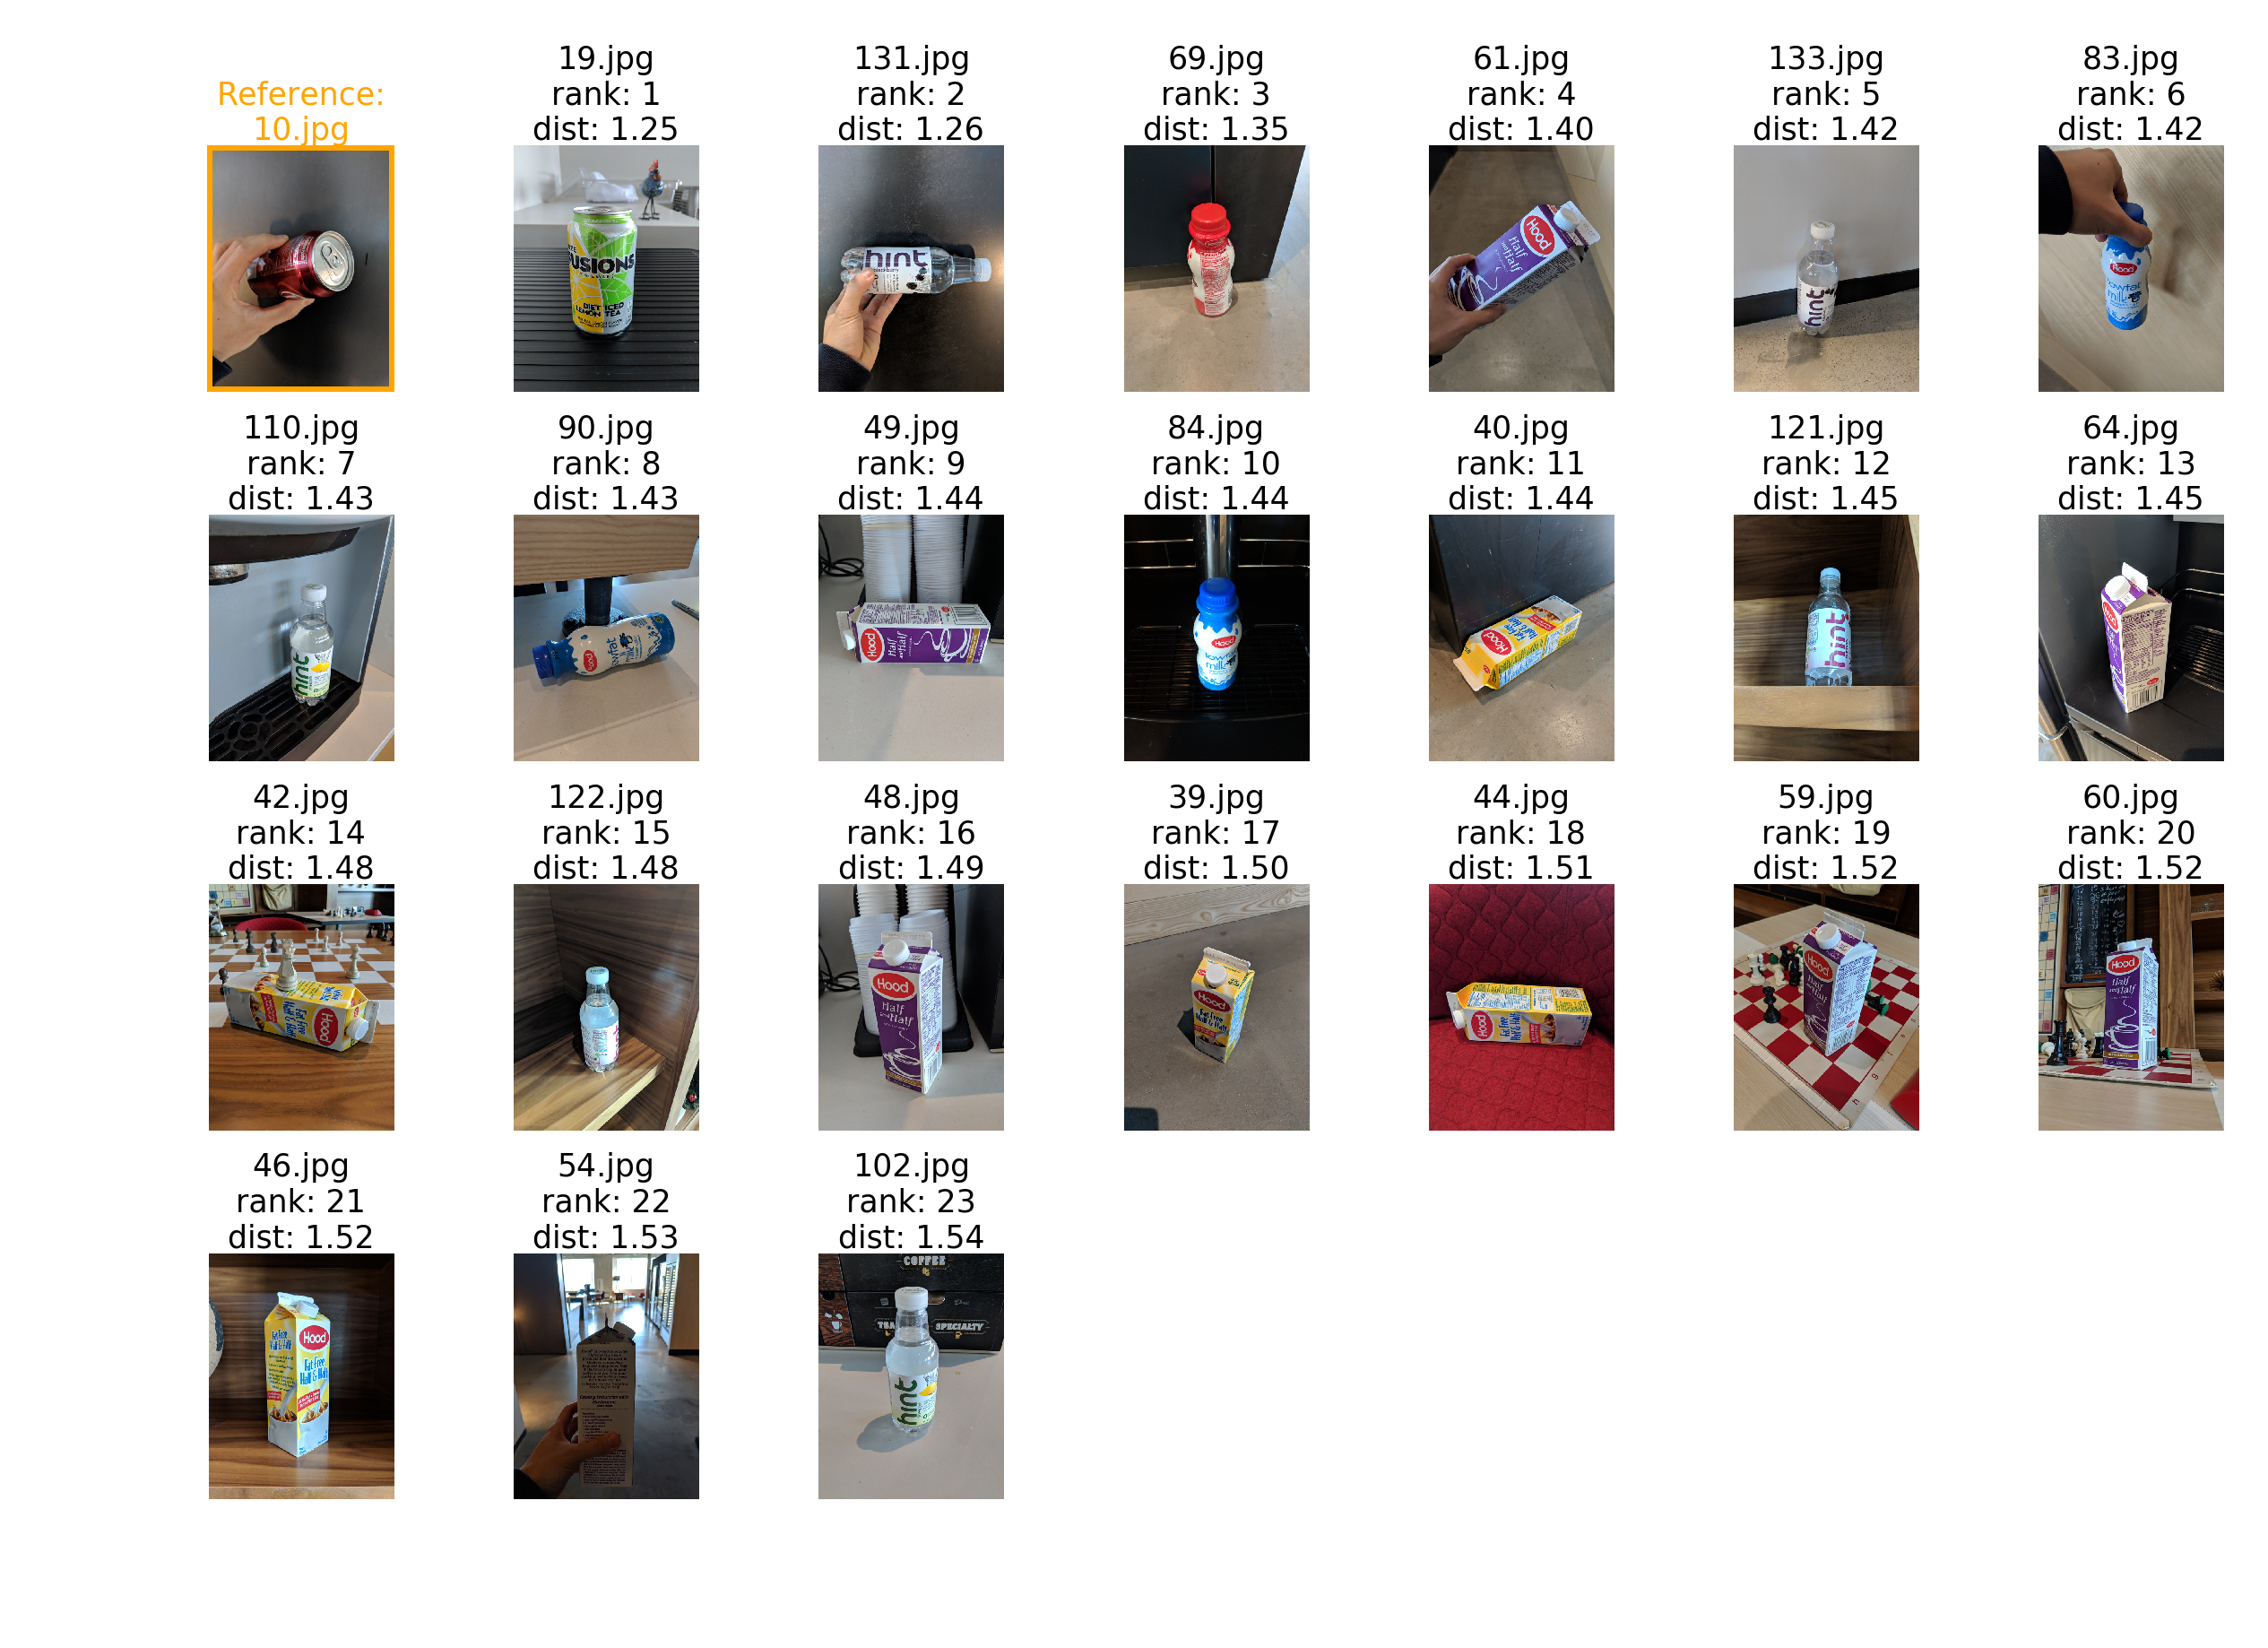

In [22]:
# Display the ranked images
num_cols = 7
num_rows = int(len(similarities_list[0])/num_cols)
plot_similars(similarities_list[0], num_rows=num_rows+1, num_cols=num_cols)

For this comparative set, the positive example was found to be the most similar to our reference image. This is what we were hoping for. In cases where the results are not as good, training on a bigger dataset, or changing the [dropout rate `ps`](https://docs.fast.ai/vision.learner.html#cnn_learner) or the learning rate may improve the outcome.

## 5. Performance metrics <a id="performance"/>

To assess our model performance and the "goodness" of our results properly, we need to define specific metrics.

Here, we focus on:
- Positive in top k: Throughout all comparative sets, for how many of them were we able to get the positive example in the top k similar images?
- Median rank: Median rank of the positive example across all comparative sets.

Ideally, our metrics would be equal to 100% and 1, respectively, which means that the positive image would always be found in the top k images, and would actually be the closest to the reference.

So, let's compute these metrics and plot the distribution of ranks we obtained.

In [16]:
ranklist, medianrank = positive_image_median_rank(similarities_list)
print(f"The positive example ranks {medianrank}, as a median, across our {len(ranklist)} comparative sets")

The positive example ranks 1.0, as a median, across our 26 comparative sets


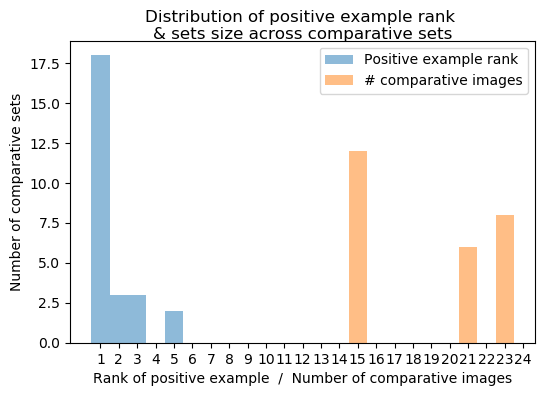

In [17]:
# Size of largest comparative set
set_sizes = [len(comparative_sets[x]) for x in comparative_sets]

# Display distribution of positive example rank
# and of size of comparative sets (as it varies across sets)
plot_rank(ranklist, set_sizes, both=True)

# Use both=False to only display the distribution of ranks

In [18]:
print(f"The positive image is:\n --> {positive_in_top_k(ranklist, 10)}% of the time in the top 10 images\
      \n --> {positive_in_top_k(ranklist, 5)}% of the time in the top 5 images \
      \n --> {positive_in_top_k(ranklist, 1)}% of the time the most similar to the reference.")

The positive image is:
 --> 100.0% of the time in the top 10 images      
 --> 100.0% of the time in the top 5 images       
 --> 69.2% of the time the most similar to the reference.


## 6. Next steps <a id="next"/>

The best results for image similarity are typically obtained when the model trained is a siamese network or when it leverages triplet loss. This is what we will plan on sharing soon. In the meantime, we can try and train this model with a bigger dataset.

## Appendix <a id="appendix"/>

### A. Alternative visualization tool

With our `DistanceWidget`, we can display the results in a different fashion. Here we can interact with a user interface and navigate between the images of a comparative set, in distance order. In the example below, we consider the last comparative set we processed.

In [19]:
# Extract the last comparative set
# It contains a list of tuples: (image path, distance from reference)
last_comparative_set = similarities_list[-1]

# Extract the Path() object for each of the comparative images in this set
im_paths = [Path(tup[0]) for tup in last_comparative_set]

# Extract the labels from the paths of the images
labels = [Path(tup[0]).parts[-2] for tup in last_comparative_set]

# Extract the path of the root of our FridgeObjects dataset
path = Path(last_comparative_set[0][0]).parent.parent

# Create an ImageDataBunch, which is expected by our DistanceWidget below
data2 = ImageDataBunch.from_lists(path, im_paths, labels=labels, bs=len(labels), valid_pct=0.)

In [20]:
# Construct the *DistanceWidget* object by passing:
# - the data from the *data2* object
# - the respective distances that are stored in the *last_comparative_set* object
w_results = DistanceWidget(
    dataset=data2.train_ds,
    distances=np.asarray([tup[1] for tup in last_comparative_set])
)

# Display the widget
display(w_results.show())

### B. Alternative way of retrieving the most similar images

In the dataset we used here, the maximum number N of images we had in our comparative sets was small (N=23). We could then afford to compute the distance between our reference and all the other images in each of our sets. In a real life scenario, however, the size of the comparative set may be very big, with thousands of images or more. Using brute force to search for the top k nearest neighbors then becomes inefficient. In that case, it is preferable to use an approximate method that is optimized for large (N) and high dimensional (D) datasets. A [Ball Tree](https://scikit-learn.org/stable/modules/neighbors.html#ball-tree) is a solution often considered, as its query time grows as [O\[Dlog(N)\]](https://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm), compared to O\[DN\] for brute force.

In the cells below, we demonstrate how to extract the TOP_K images using a Ball Tree, on the last of our comparative sets.

<i><b>Notes:</b></i>
- In our case, the number of image embeddings is &lt; 30, so the best method to use is the brute force, as we did initially.
- Other solutions, such as [locality sensitive hashing](https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23) (LSH) are also popular to find nearest neighbors in large, high dimensional datasets. This [library](https://pypi.org/project/LocalitySensitiveHashing/) is an example implementation in python.

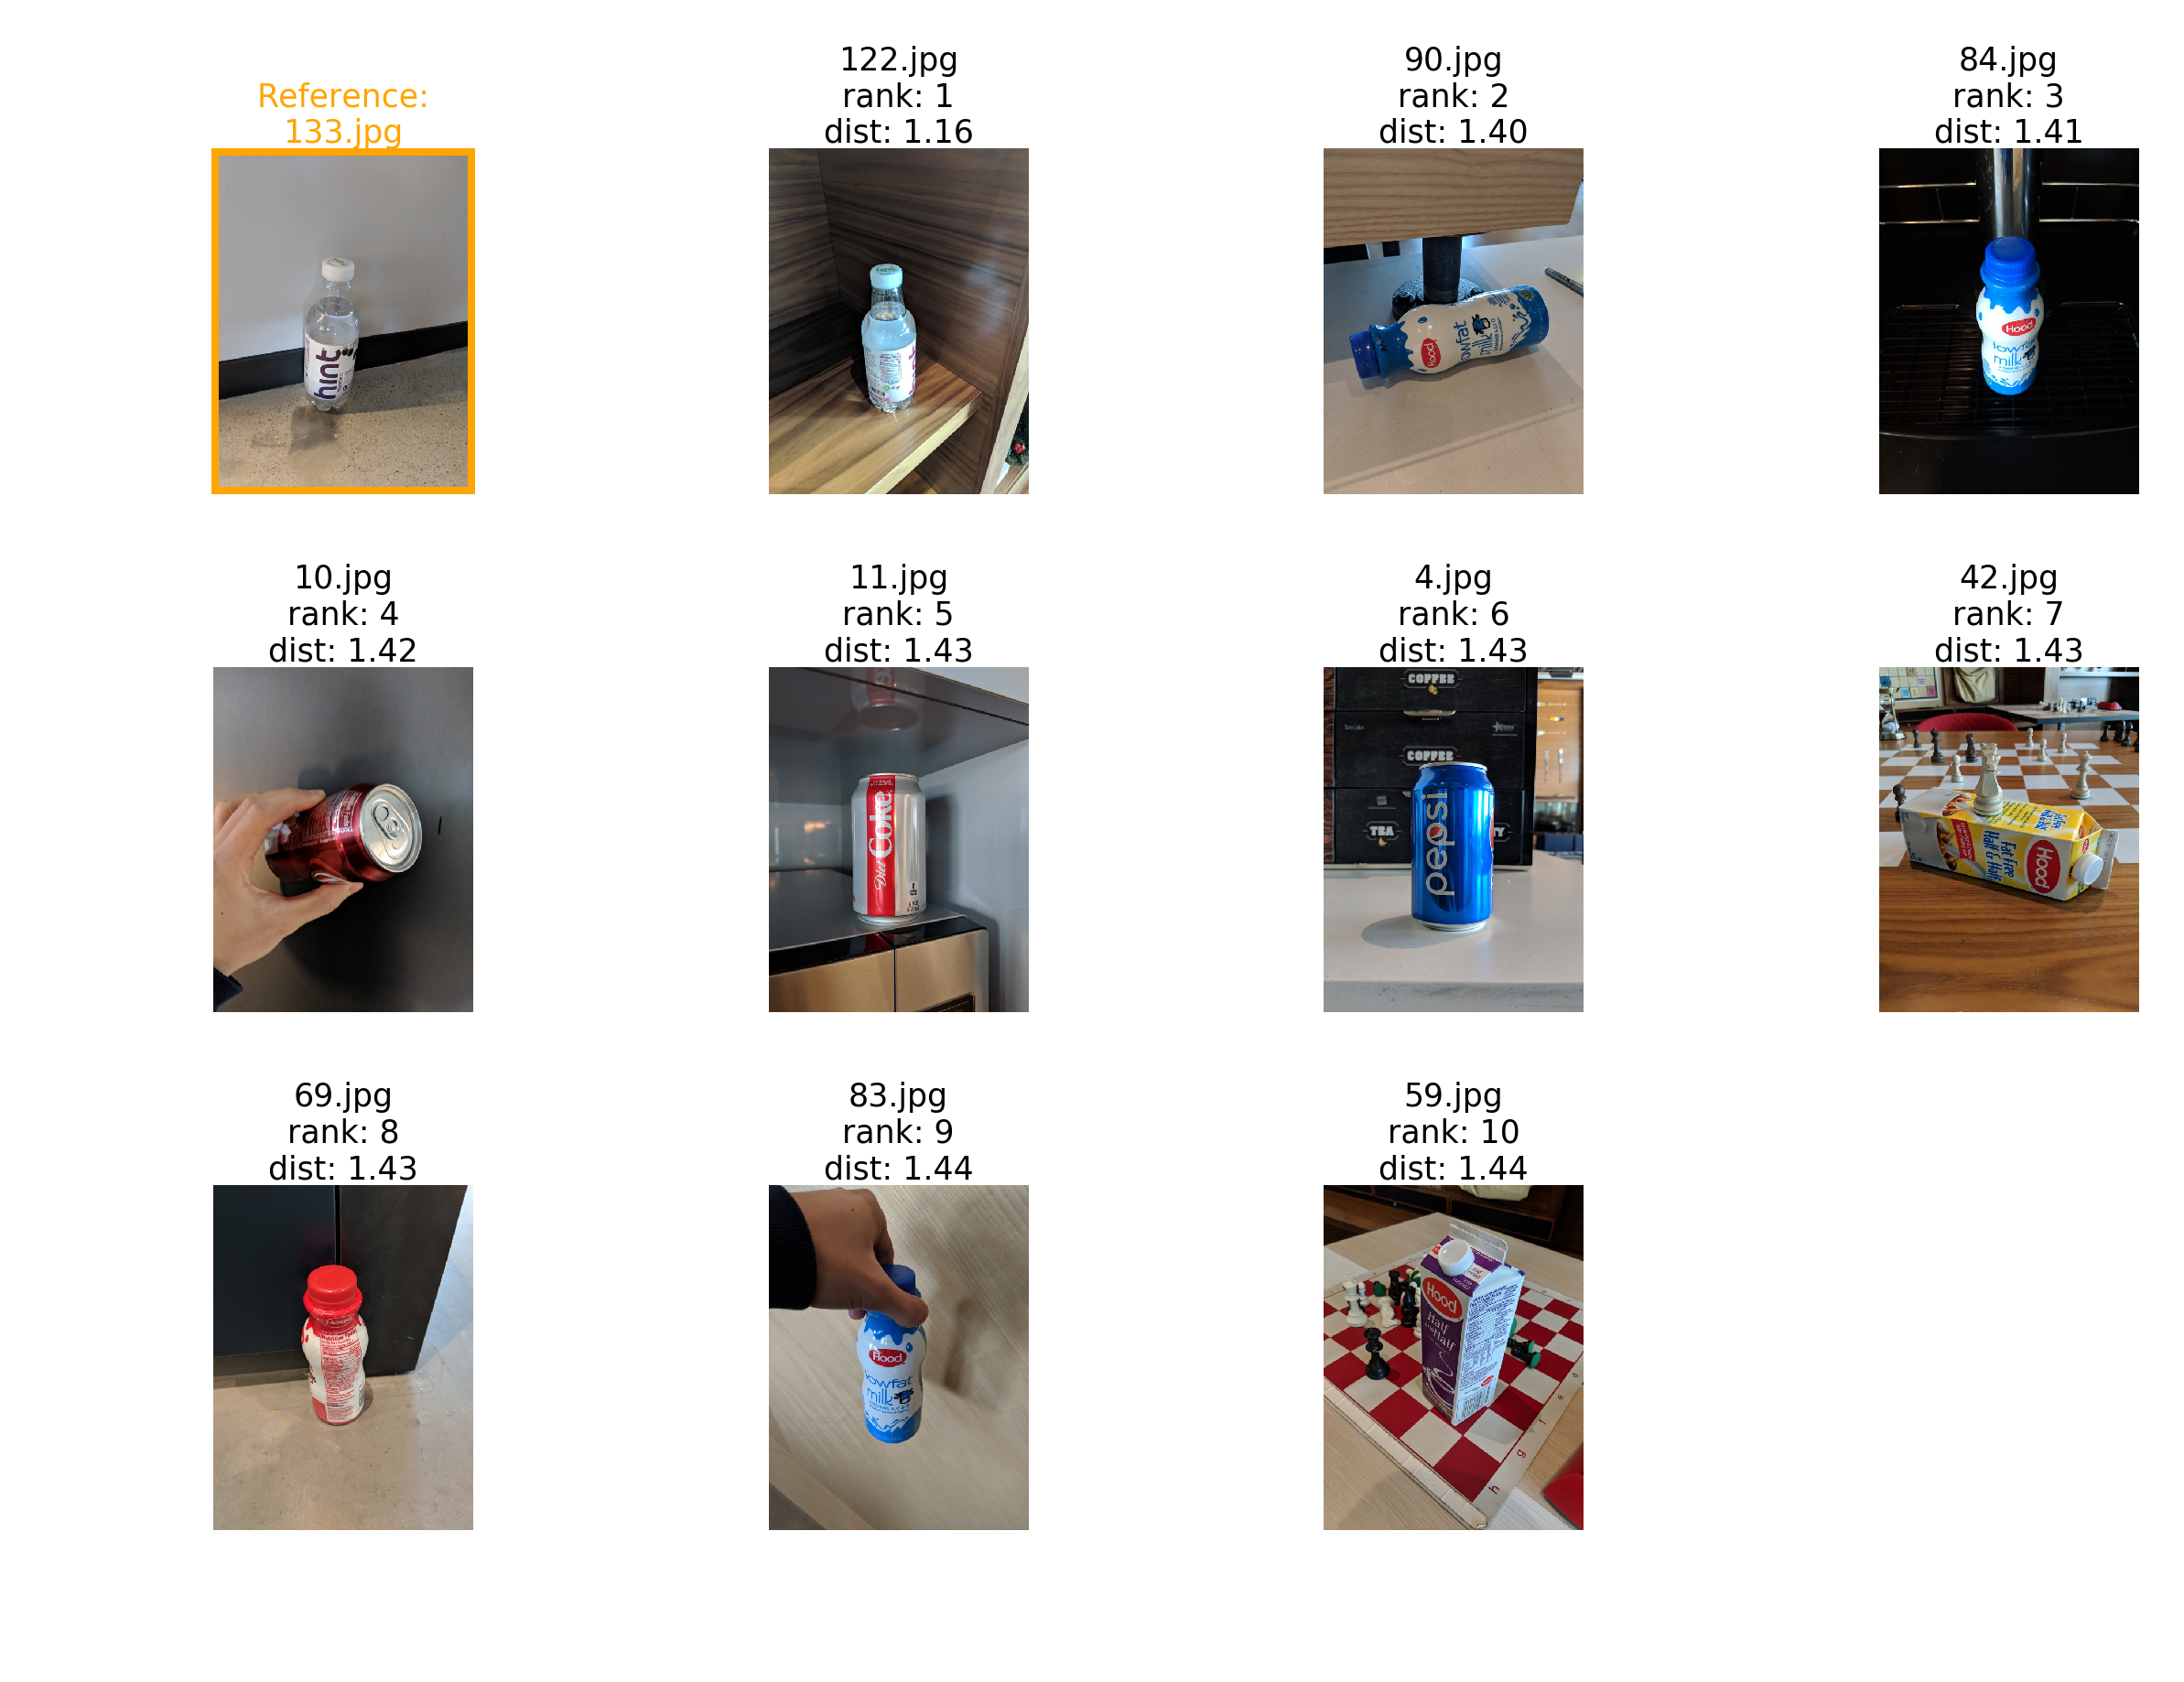

In [21]:
# Build the tree with all our image embeddings
normalized_features = features / np.linalg.norm(features, axis=1).reshape(features.shape[0],1)
btree = BallTree(normalized_features, leaf_size=5, metric='euclidean')
# We normalized the embeddings, and chose "euclidean" to match our "L2" distance from above

# Query the tree for only the reference image
reference_im_embedding = np.reshape(normalized_features[0,:], (-1, 512))
top_k_closest_im = btree.query(reference_im_embedding, k=TOP_K+1, return_distance=True)

# Notes:
# 1. We convert the reference image embedding into a 2D array so it has the same last dimension as the *features* object
# 2. We reduce *leaf_size* from 30 to 5 to force BallTree to execute as BallTree and not in the Brute Force mode
# 3. *btree.query()* returns a tuple of arrays: (array of distances, array of image indices), 
#    where each array is of shape (comparative set size, TOP_K+1)

# Sort the image paths in the order returned by the query to the Ball Tree
sorted_im_paths = itemgetter(*top_k_closest_im[1][0])(comparative_set_paths)
# Extract the associated distances
distances = top_k_closest_im[0][0]
# Build the list of (image path, distance to reference image) needed for our *plot_similars* function
similar_from_tree = [(im_path, dist) for im_path, dist in zip(sorted_im_paths, distances)]
# Display the results
plot_similars(similar_from_tree, num_rows=3, num_cols=4)

Depending on the comparative set, the results may be slightly different from those obtained using an exact nearest neighbors method.